# Roi-based traces

In [1]:
import numpy as np
import cv2
import tifffile
import h5py
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

from vis_utils import *

## First, read the locations from DLC

In [2]:
which_neuron = 7
num_frames = 100
sz=(18,18)

In [3]:
# Raw video
# folder_name = '/users/charles.fieseler/test_worm1_data/mCherry_slices_long/'
# fname = 'test_1000frames_13sliceDLC_resnet50_WormTestJul16shuffle1_34000.h5'
# fname = os.path.join(folder_name, fname)

# Pre-aligned (within volumes)
folder_name = '/users/charles.fieseler/test_worm1_data/mCherry_volume_aligned/'
fname = 'test_100frames_13sliceDLC_resnet50_volume_aligned_aviJul20shuffle1_5500.h5'
# fname = 'test_100frames_13sliceDLC_resnet50_volume_aligned_aviJul20shuffle1_4500.h5' # Tightened training

annotation_fname = os.path.join(folder_name, fname)

this_xy, this_prob = xy_from_dlc_dat(annotation_fname, which_neuron=which_neuron, num_frames=num_frames)

Text(0.5, 1.0, 'Confidence of tracking')

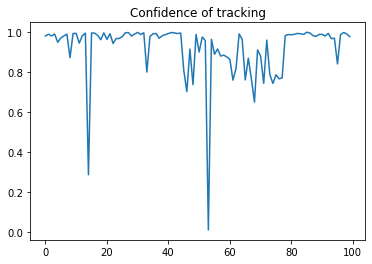

In [4]:
plt.plot(this_prob)
plt.title('Confidence of tracking')

## Next, read in 3d video

In [35]:
which_z = 13 # The actually tracked slice
num_frames = 50
sz=(201,201,11)

In [36]:
folder_name = '/users/charles.fieseler/test_worm1_data/mCherry_volume_aligned/'
fname = 'test_100frames.ome.tiff'
# Pre-aligned and background subtracted
# fname = 'test_bg_subtract_100frames.ome.tiff'

video3d_fname = os.path.join(folder_name, fname)

cropped_dat = get_crop_from_ometiff(video3d_fname, this_xy, which_z, num_frames, sz)

Reading video...
Read video of shape (100, 39, 650, 850)
Reading frame 0/49 at position [451.515625   185.43045044  13.        ]
Reading frame 1/49 at position [209.50746155 325.68475342  13.        ]
Reading frame 2/49 at position [391.40966797 427.63674927  13.        ]
Reading frame 3/49 at position [412.24954224 276.28253174  13.        ]
Reading frame 4/49 at position [500.80776978 230.54702759  13.        ]
Reading frame 5/49 at position [444.69400024 197.21801758  13.        ]
Reading frame 6/49 at position [425.56283569 366.03787231  13.        ]
Reading frame 7/49 at position [437.87957764 131.86729431  13.        ]
Reading frame 8/49 at position [508.41940308 130.55912781  13.        ]
Reading frame 9/49 at position [456.88497925  33.77458572  13.        ]
Reading frame 10/49 at position [385.60809326 229.50692749  13.        ]
Reading frame 11/49 at position [601.2130127  282.32281494  13.        ]
Reading frame 12/49 at position [442.4887085  334.32943726  13.        ]
Read

In [37]:
f = lambda z, t : plt.imshow(cropped_dat[:,:,z,t], vmin=100, vmax=500)
print("Cropped data")
interact(f, **{'t':(0,num_frames-1), 'z':(0,sz[2]-1)})

Cropped data


interactive(children=(IntSlider(value=5, description='z', max=10), IntSlider(value=24, description='t', max=49…

<function __main__.<lambda>(z, t)>

## Find Peaks in 3d

In [38]:
peaks_ind = np.zeros((num_frames,3))
peaks_val = []
frame_sz = cropped_dat.shape[:-1]
for t in range(num_frames):
    frame = cropped_dat[...,t]
    max_ind = np.argmax(frame)
    max_ind = np.unravel_index(max_ind, frame_sz)
    peaks_ind[t,:] = np.array(max_ind)
    peaks_val.append(frame[max_ind])


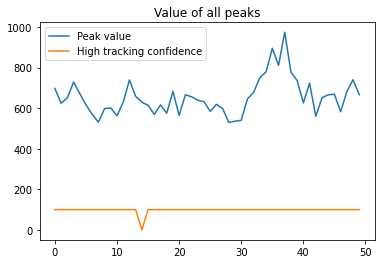

In [39]:
plt.plot(peaks_val)
plt.plot(100*np.array([i>0.6 for i in this_prob[:num_frames]]))
plt.legend(('Peak value', 'High tracking confidence'))
plt.title('Value of all peaks');

In [40]:
# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(peaks_ind[:,0], peaks_ind[:,1], peaks_ind[:,2])
# plt.title('All peak locations')

In [41]:
# interact(plot3d_with_max, t=(0,num_frames-1), z=(0,sz[2]-1), max_ind=fixed(peaks_ind))
# f = lambda t, z : plot3d_with_max(cropped_dat, z, t, peaks_ind)
# interact(f, **{'t':(0,num_frames-1), 'z':(0,sz[2]-1)})

interactive(children=(IntSlider(value=24, description='t', max=49), IntSlider(value=5, description='z', max=10…

<function __main__.<lambda>(t, z)>

## Do a Gaussian blur, then find the peaks again

In [42]:
import cv2
from itertools import product

In [43]:
cropped_dat.shape

(201, 201, 11, 50)

In [44]:
blurred_dat = np.zeros_like(cropped_dat)
sz = blurred_dat.shape
for z, t in product(range(sz[2]), range(sz[3])):
    blurred_dat[:,:,z,t] = cv2.GaussianBlur(cropped_dat[:,:,z,t],(5,5),0)

In [45]:
peaks_ind = np.zeros((num_frames,3))
peaks_val = []
frame_sz = blurred_dat.shape[:-1]
for t in range(num_frames):
    frame = blurred_dat[...,t]
    max_ind = np.argmax(frame)
    max_ind = np.unravel_index(max_ind, frame_sz)
    peaks_ind[t,:] = np.array(max_ind)
    peaks_val.append(frame[max_ind])


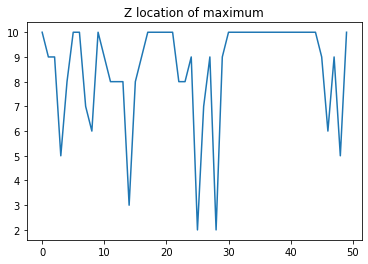

In [46]:
plt.plot(peaks_ind[:,2])
plt.title('Z location of maximum');
plt.savefig('z_of_max')

In [47]:
# interact(plot3d_with_max, t=(0,num_frames-1), z=(0,sz[2]-1), max_ind=fixed(peaks_ind))
# interact(plot3d_with_max, **{'t':(0,num_frames-1), 'z':(0,sz[2]-1), 'max_ind':fixed(peaks_ind)});

In [48]:
f = lambda t, z : plot3d_with_max_and_hist(cropped_dat, z, t, peaks_ind)
# interact(plot3d_with_max, t=(0,num_frames-1), z=(0,sz[2]-1), max_ind=fixed(peaks_ind))
interact(f, **{'t':(0,num_frames-1), 'z':(0,sz[2]-1)});

interactive(children=(IntSlider(value=24, description='t', max=49), IntSlider(value=5, description='z', max=10…

In [61]:
f = lambda t : plt.imshow(np.max(cropped_dat[...,t], axis=2), vmin=100, vmax=500)
interact(f, **{'t':(0,num_frames-1)});

interactive(children=(IntSlider(value=24, description='t', max=49), Output()), _dom_classes=('widget-interact'…

In [57]:
cropped_dat.shape

(201, 201, 11, 50)

In [ ]:
plt.plot(peaks_ind[:,2])
plt.title('Z location of maximum');

## Take a 3x3x3 average around the peak

In [ ]:
peaks333_val = np.zeros_like(peaks_val)
# peaks333_val_blur = np.zeros_like(peaks_val)
crop_sz=(3,3,3)
clip_sz=cropped_dat.shape

for i in range(num_frames):
    x_ind, y_ind, z_ind = get_crop_coords3d(peaks_ind[i,:], crop_sz, clip_sz=clip_sz)
    peaks333_val[i] = np.mean(cropped_dat[...,i][x_ind,:,:][:, y_ind,:][:,:, z_ind])
#     peaks333_val_blur[i] = np.mean(blurred_dat[...,i][x_ind,:,:][:, y_ind,:][:,:, z_ind])
    if peaks333_val[i] == 0:
        print(x_ind, y_ind, z_ind)


In [ ]:
plt.plot(peaks333_val)
# plt.plot(peaks333_val_blur)
plt.plot(peaks_val)
# plt.legend(('3x3x3 box', '3x3x3 box on blurred data', 'Peak value'))
plt.legend(('3x3x3 box', 'Peak value'))
plt.title('Mean of 3x3x3 box around the peak');

## Same neuron, but with GCaMP

In [1]:
import numpy as np
import cv2
import tifffile
import h5py
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

from vis_utils import *

In [14]:
folder_name = '/users/charles.fieseler/test_worm1_data/mCherry_slices/'
fname = 'test_100frames_13sliceDLC_resnet50_WormTestJul9shuffle1_64000.h5' # Use tracked mCherry
annotation_fname = os.path.join(folder_name, fname)

which_neuron = 1;
num_frames = 50;

this_xy, this_prob = xy_from_dlc_dat(annotation_fname, which_neuron=which_neuron, num_frames=num_frames)

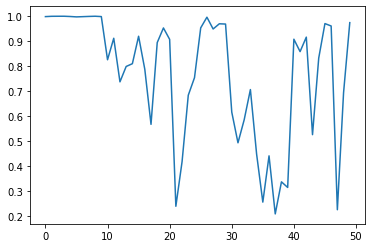

In [15]:
plt.plot(this_prob)

In [16]:
folder_name = '/users/charles.fieseler/test_worm1_data/mCherry_slices/'
fname = 'test_100frames_13slice.avi' # Use tracked mCherry
video_fname = os.path.join(folder_name, fname)

sz = (20, 20)

cropped_dat = get_crop_from_avi(video_fname, this_xy, num_frames, sz=(28,28))

In [17]:
peaks_ind = np.zeros((num_frames,3))
peaks_val = []
frame_sz = cropped_dat.shape[:-1]
for t in range(num_frames):
    frame = cropped_dat[...,t]
    max_ind = np.argmax(frame)
    max_ind = np.unravel_index(max_ind, frame_sz)
    peaks_ind[t,:] = np.array(max_ind)
    peaks_val.append(frame[max_ind])

In [18]:
f = lambda t : plot3d_with_max_and_hist(cropped_dat, 0, t, peaks_ind)
interact(f, **{'t':(0,num_frames-1)});

interactive(children=(IntSlider(value=24, description='t', max=49), Output()), _dom_classes=('widget-interact'…

# Scratch

Fit a 3d Gaussian

Based on:
https://stackoverflow.com/questions/24666877/2d-gaussian-fitting-to-histogram

In [42]:
def mult_gaussFun_Fit(x,y,z,*m):
    A,x0,y0,z0,varx,vary,varz,rho,alpha = m
    X,Y,Z = np.meshgrid(x,y,z)
    assert rho != 1
    a = 1/(2*(1-rho**2))
    dist = A*np.exp(-a*( (X-x0)**2/(varx) + (Y-y0)**2/(vary) + (Z-z0)**2/(varz) - (2*rho/(np.sqrt(varx*vary*varz) ) )*(X-x0)*(Y-y0)*(Z-z0)))
    return dist.ravel()

In [43]:
from scipy.optimize import curve_fit

In [52]:
# Produce a number of points in x-y from 1 distribution. 
mean = [0,0,0]
cov = np.eye(3)
N = 3000
# x,y,z = np.random.multivariate_normal(mean,cov,N).T
xyz = np.random.multivariate_normal(mean,cov,N)

In [53]:
xyz.shape

(3000, 3)

In [54]:
H, edges = np.histogramdd(xyz)

In [ ]:
# Prep bins for histogram
bin_size = 0.2
max_edge = 2.5*(np.sqrt(cov[0][0])+np.sqrt(cov[1][1])) 
min_edge = -max_edge
bin_num = (max_edge-min_edge)/bin_size
bin_numPlus1 = bin_num + 1
bins = np.linspace(min_edge,max_edge,bin_numPlus1)

# Produce 2D histogram
H,xedges,yedges = np.histogram2d(x,y,bins,normed=False)
bin_centers_x = (xedges[:-1]+xedges[1:])/2.0
bin_centers_y = (yedges[:-1]+yedges[1:])/2.0

In [ ]:
# Initial Guess
p0 = (H.max(),mean[0],mean[1],cov[0][0],cov[1][1],0.5,np.pi/4)

# Curve Fit parameters
coeff, var_matrix = curve_fit(gauss.mult_gaussFun_Fit,(bin_centers_x,bin_centers_y),H,p0=p0)

## Actually just do a Gaussian kernel

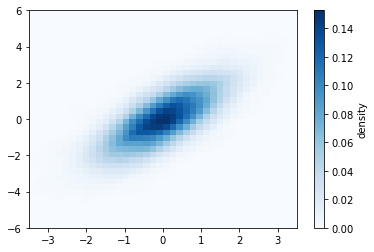

In [60]:
mean = [0, 0]
cov = [[1, 1], [1, 2]]
x, y = np.random.multivariate_normal(mean, cov, 10000).T

# fit an array of size [Ndim, Nsamples]
data = np.vstack([x, y])
kde = gaussian_kde(data)

# evaluate on a regular grid
xgrid = np.linspace(-3.5, 3.5, 40)
ygrid = np.linspace(-6, 6, 40)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

# Plot the result as an image
plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[-3.5, 3.5, -6, 6],
           cmap='Blues')
cb = plt.colorbar()
cb.set_label("density")

(array([ 0.02787812, -0.49209117, -1.24973747, ..., -0.29762827,
        -1.51089312, -0.09095426]),
 array([ 0.15469938, -0.16263896, -2.33547902, ..., -0.49756739,
        -1.4176045 ,  0.31548077]))